In [1]:
import os
import yaml
from torch.utils.data import DataLoader
import argparse

from GeospatialFM.data import get_datasets
from GeospatialFM.models import *
# from utils import load_config
from torchgeo.samplers import RandomGeoSampler
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

from transformers import TrainingArguments, Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from GeospatialFM.utils import setup, get_eval_meter, get_data, init_distributed_device, get_datasets
from GeospatialFM.data import *
from GeospatialFM.models import *
from GeospatialFM.loss import *

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np
from torch.utils.data import ConcatDataset
import segmentation_models_pytorch as smp
from collections import OrderedDict
from omegaconf import OmegaConf

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SENTINEL_WV = [442.7, 492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 832.8, 864.7, 945.1, 1373.5, 1613.7, 2202.4]

In [3]:
def norm_image(img):
    img = img - img.min()
    img = img / img.max()
    return img

In [4]:
data_name = 'BigEarthNet'
data_cfg_path = f'GeospatialFM/configs/datasets/{data_name.lower()}.yaml'

In [5]:
cfg = OmegaConf.load(data_cfg_path).DATASET
cfg

{'root': './data/geospatial', 'name': 'BigEarthNet', 'train_transforms': {'normalize': True, 'standardize': False}, 'eval_transforms': {'normalize': True, 'standardize': False}, 'kwargs': {'bands': 'all', 'num_classes': 19, 'pad_s2': False}, 'eval_metric': 'mAP', 'metric_of_interest': 'micro_mAP', 'task_type': 'multilabel', 'use_train_transform': True, 'train_frac': 0.1, 'val_frac': 0.1, 'train_split': 'train', 'task_head_kwargs': {'head_type': 'linear', 'num_classes': 19}}

In [6]:
train, val, test = get_datasets(cfg)

Training Dataset: BigEarthNet
Train Set: 26969	 Val Set: 12372	 Test Set: 125866


In [7]:
class_names = train.dataset.class_sets
if isinstance(class_names, dict):
    class_names = class_names[19]
class_names

['Urban fabric',
 'Industrial or commercial units',
 'Arable land',
 'Permanent crops',
 'Pastures',
 'Complex cultivation patterns',
 'Land principally occupied by agriculture, with significant areas of natural vegetation',
 'Agro-forestry areas',
 'Broad-leaved forest',
 'Coniferous forest',
 'Mixed forest',
 'Natural grassland and sparsely vegetated areas',
 'Moors, heathland and sclerophyllous vegetation',
 'Transitional woodland, shrub',
 'Beaches, dunes, sands',
 'Inland wetlands',
 'Coastal wetlands',
 'Inland waters',
 'Marine waters']

Urban fabric

Land principally occupied by agriculture, with significant areas of natural vegetation

Broad-leaved forest

Marine waters



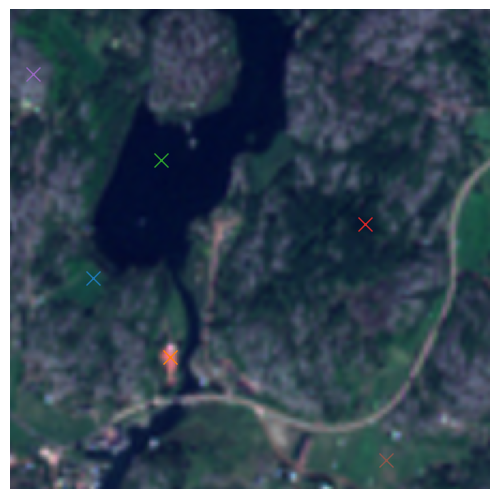

In [8]:
vis_idx = 41982
vis_split = test
sample_rgb_image = vis_split[vis_idx]['image'][[3, 2, 1]].numpy()
sample_rgb_image = norm_image(sample_rgb_image)
# Create a figure and axis with no frame
random_locs = [[125, 38], [162, 74], [70, 70], [100, 165], [30, 10], [210, 175]]

fig, ax = plt.subplots(frameon=False)

# Make the content fill the whole figure
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

# Display the image
ax.imshow(sample_rgb_image.transpose(1, 2, 0))

for loc in random_locs:
    ax.plot(loc[1], loc[0], 'x', markersize=10, markeredgewidth=1)

# Hide the axis
ax.axis('off')
sample_labels = vis_split[vis_idx]['label'].numpy().astype(int)
if len(sample_labels) > 1:
    assert len(sample_labels) == len(class_names)
    labels = [class_names[i] for i, l in enumerate(sample_labels) if l == 1]
for label in labels:
    print(label+'\n')

In [11]:
vis_idx = 41982
vis_split = test
sample_optical_image = vis_split[vis_idx]['image'].numpy()
# sample_optical_image = np.delete(sample_optical_image, 10, axis=0)
sentinel_wv = np.delete(SENTINEL_WV, 10)
sample_optical_image.shape, sentinel_wv.shape

((12, 224, 224), (12,))

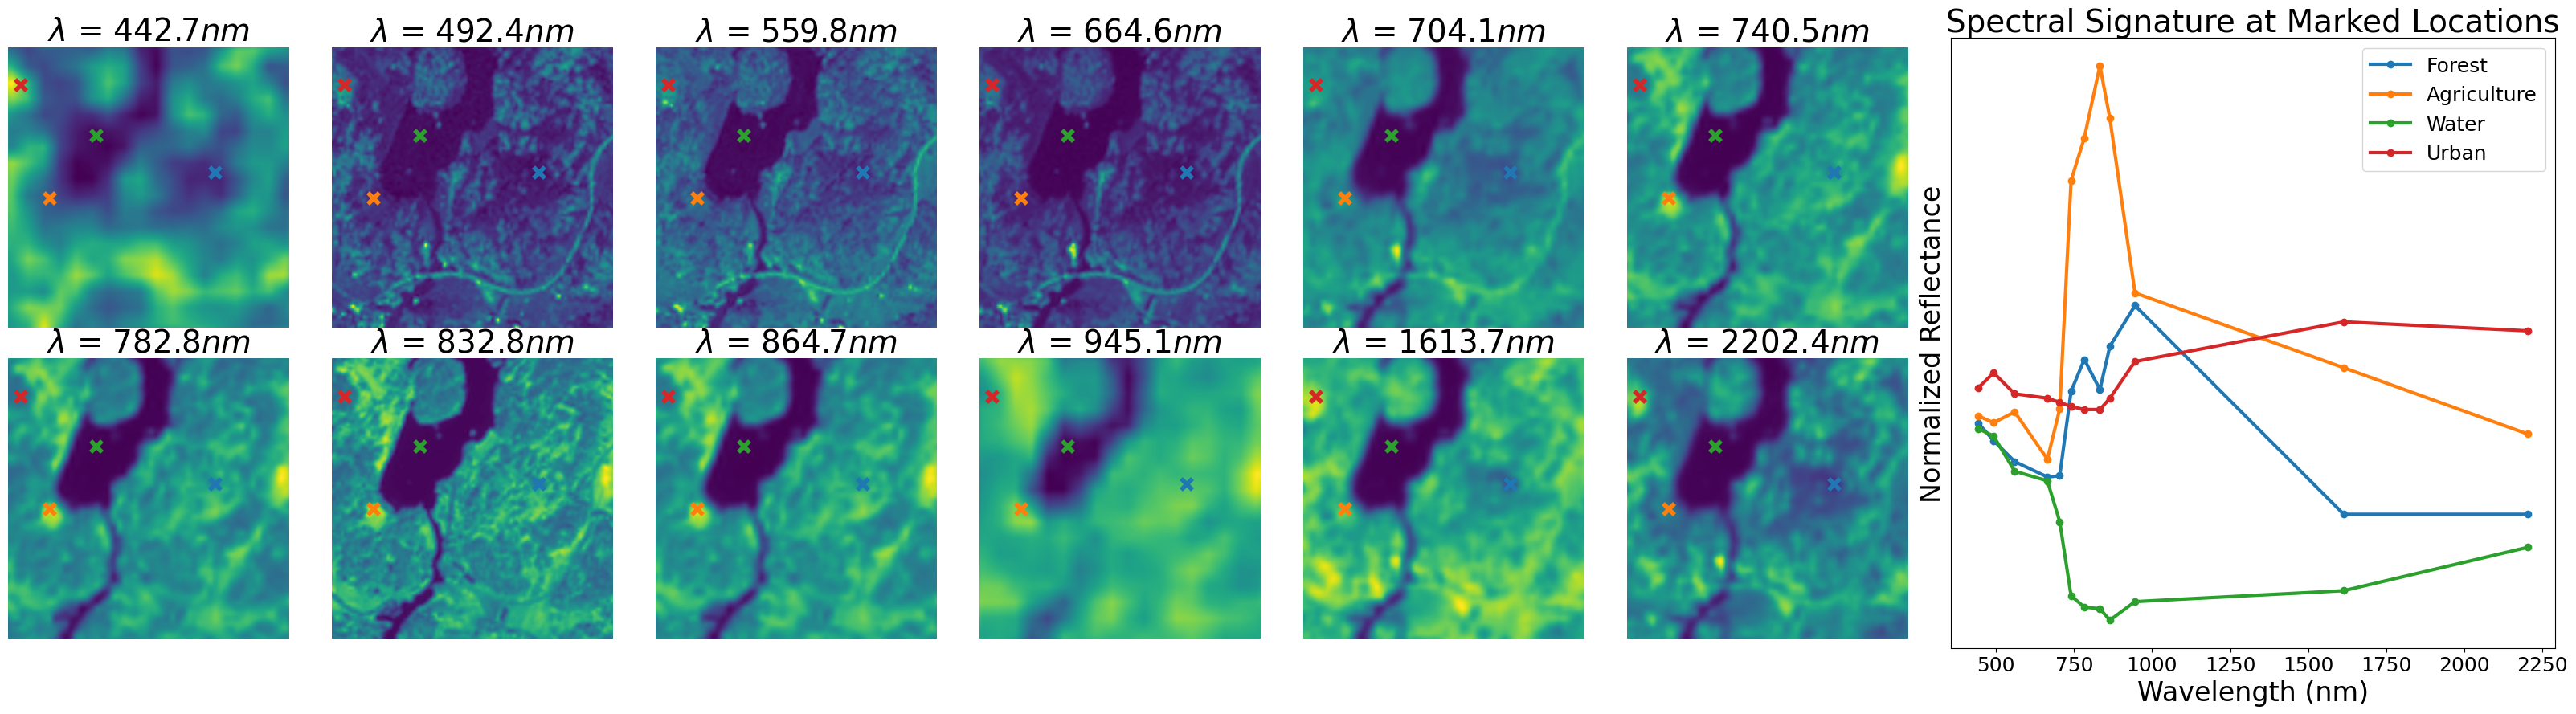

In [20]:
mpl.rcParams['axes.titlesize'] = 28
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

# Number of images excluding the RGB image
num_images = 12  # for example
# random_locs = [[70, 70], [99, 99], [150, 150], [200, 200]]
random_locs = [[125, 38], [162, 74], [70, 70], [100, 165], [30, 10], [210, 175]]
# random_locs = [[70, 70], [100, 165], [30, 10], [210, 175]]
random_locs = [[100, 165], [120, 33], [70, 70], [30, 10]]
target_labels = ['Forest', 'Agriculture', 'Water', 'Urban']

# Create a figure
fig = plt.figure(figsize=(32, 9))  # Adjust the figure size as needed

# Create a GridSpec with 3 rows and 4 columns
gs = GridSpec(2, 8, figure=fig)

# The rest of the images (adjust the range according to your number of images)
for i in range(num_images):
    # Calculate the position for the current image
    row = i // 6
    col = i % 6 
    ax = fig.add_subplot(gs[row, col])
    ax.imshow(sample_optical_image[i])  # Replace with each individual image array
    # plot cross at random locations
    for loc in random_locs:
        ax.plot(loc[1], loc[0], 'x', markersize=10, markeredgewidth=4)
    # bold the title
    ax.set_title(f"$\lambda$ = {sentinel_wv[i]}$nm$")  # Replace with the title for each image
    # ax.set_title(f"$\lambda$ = {sentinel_wv[i]}$nm$")  # Replace with the title for each image
    ax.axis('off')
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_xlabel(f"$\lambda$ = {sentinel_wv[i]}$nm$")

ax_curve = fig.add_subplot(gs[:, -2:])
for loc, label in zip(random_locs, target_labels):
    ax_curve.plot(sentinel_wv, sample_optical_image[:, loc[0], loc[1]], linewidth=3, marker='o', markersize=6, label=label)
ax_curve.legend(loc='upper right', fontsize=18)
ax_curve.set_xlabel('Wavelength (nm)')
ax_curve.set_ylabel('Normalized Reflectance')
ax_curve.set_title('Spectral Signature at Marked Locations')
ax_curve.set_yticks([])
# log x scale
# ax_curve.set_xscale('log')
# ax_curve.set_xticks(sentinel_wv)
# ax_curve.set_xticklabels(sentinel_wv, rotation=45)
# ax_curve.axis('equal')
# enabel tight layout

plt.tight_layout()
# plt.show()
# save as pdf
# plt.savefig('spectral_signature.pdf', bbox_inches='tight', pad_inches=0.1)

In [ ]:
vis_idx = 41982
vis_split = test
sample_optical_image = vis_split[vis_idx]['image'].numpy()
sample_optical_image = np.delete(sample_optical_image, 10, axis=0)

sample_radar_image = vis_split[vis_idx]['radar'].numpy()

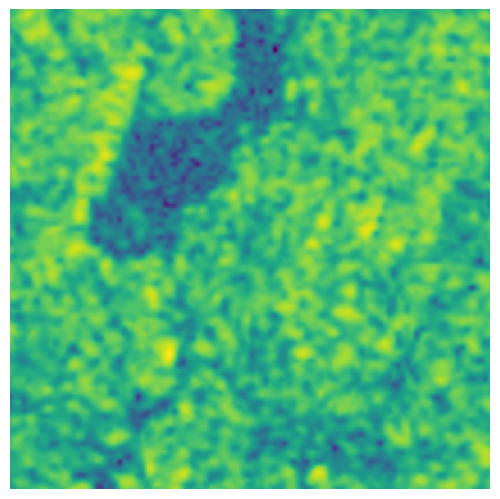

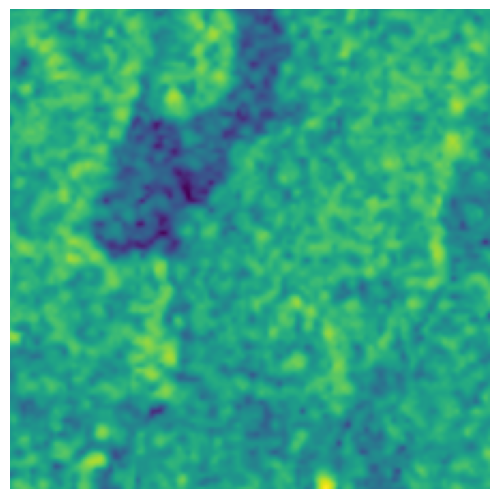

In [ ]:
# for optical_idx in range(12):
#     fig, ax = plt.subplots(frameon=False)
#     # Make the content fill the whole figure
#     fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
#     # Display the image
#     ax.imshow(sample_optical_image[optical_idx])
#     # Hide the axis
#     ax.axis('off')
#     # save the figure
#     plt.savefig(f'save_figs/optical_image_{optical_idx}.png', bbox_inches='tight', pad_inches=0)

# for radar_idx in range(2):
#     fig, ax = plt.subplots(frameon=False)
#     # Make the content fill the whole figure
#     fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
#     # Display the image
#     ax.imshow(sample_radar_image[radar_idx])
#     # Hide the axis
#     ax.axis('off')
#     # save the figure
#     plt.savefig(f'save_figs/radar_image_{radar_idx}.png', bbox_inches='tight', pad_inches=0)